Hello! I,Vishal Sharma, am the creator of this data-set and just wanted to provide a sample analysis for anyone interested in looking at CS. I look at mainly the pistol round here but many of the techniques can be applied to all types of rounds. There are many ways to analyze this dataset so I hope you can go off and answer interesting questions for yourself :)

The following questions will be answered in this notebook:

What are the most common pistol round buys?
What is the ADR by each pistol on pistol rounds?
What sites do bomb get planted the most on pistol rounds?
After bomb gets planted at A/B Site, for all XvX situation, what is the win Probability for Ts?
In a 1v1, 1v2, 2v1, 2v2, should players play out of site/in-site or one-in one-out to deal the most damage while receiving the least?

First we will import some basic and essential libraries needed for the analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.misc import imread
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv(r'C:\Users\hp\Downloads\Compressed\csgo-matchmaking-damage\mm_master_demos.csv',index_col =0)
map_bounds = pd.read_csv(r'C:\Users\hp\Downloads\Compressed\csgo-matchmaking-damage/map_data.csv', index_col=0)

In [4]:
df.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198123082770,17,1473.847,1351.358,662.170,772.748,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,-1211.723,1060.813,-1184.006,1153.343,PISTOL_ROUND,2950,3850,16.0
2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,-1153.584,1163.131,-1198.015,1050.423,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,-1173.053,1044.365,-1141.785,1190.089,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,-1142.522,1200.967,-1157.690,1050.702,PISTOL_ROUND,2950,3850,16.0


In [4]:
map_bounds.head()

,EndX,EndY,ResX,ResY,StartX,StartY
de_cache,3752,3187,1024,1024,-2031,-2240
de_cbble,2282,3032,1024,1024,-3819,-3073
de_dust2,2127,3455,1024,1024,-2486,-1150
de_inferno,2797,3800,1024,1024,-1960,-1062
de_mirage,1912,1682,1024,1024,-3217,-3401


Data Prep
Let's first only isolate for active duty maps as they are the maps that most competitive players really care about. I also want to first convert the in-game coordinates to overhead map coordinates

In [5]:
active_duty_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']
df = df[df['map'].isin(active_duty_maps)]
df = df.reset_index(drop=True)
md = map_bounds.loc[df['map']]
md[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']] = (df.set_index('map')[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']])
md['att_pos_x'] = (md['ResX']*(md['att_pos_x']-md['StartX']))/(md['EndX']-md['StartX'])
md['att_pos_y'] = (md['ResY']*(md['att_pos_y']-md['StartY']))/(md['EndY']-md['StartY'])
md['vic_pos_x'] = (md['ResX']*(md['vic_pos_x']-md['StartX']))/(md['EndX']-md['StartX'])
md['vic_pos_y'] = (md['ResY']*(md['vic_pos_y']-md['StartY']))/(md['EndY']-md['StartY'])
df[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']] = md[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']].values

In [6]:
print("Total Number of Rounds: %i" % df.groupby(['file', 'round'])['tick'].first().count())

Total Number of Rounds: 31532


Pistol Round Buys
Let's first start by taking only pistol rounds and count the number of rounds

In [7]:
avail_pistols = ['USP', 'Glock', 'P2000', 'P250', 'Tec9', 'FiveSeven', 'Deagle', 'DualBarettas', 'CZ']

df_pistol = df[(df['round'].isin([1,16])) & (df['wp'].isin(avail_pistols))]
print("Total Number of Pistol Rounds: %i" % df_pistol.groupby(['file', 'round'])['tick'].first().count())

Total Number of Pistol Rounds: 2470


Let's first start by looking at pistol round buys. We infer this from the damage dealt by pistols each round. There is a bias here where if you did 0 damage with that pistol you had, then it doesn't get counted. The potential bias is that aim punch will make most weapons get undercounted but I don't think it's a large issue.

In [8]:
pistol_buys = df_pistol.groupby(['file', 'round', 'att_side', 'wp'])['hp_dmg'].first()
(pistol_buys.groupby(['wp']).count()/pistol_buys.groupby(['wp']).count().sum())*100.

wp
CZ               1.915270
Deagle           4.517539
DualBarettas     1.519725
FiveSeven        5.423129
Glock           26.626418
P2000           11.731029
P250             9.763714
Tec9             5.090039
USP             33.413136
Name: hp_dmg, dtype: float64

Looks like Glock/USP trumps over most pistols.

Heatmaps of Frequency of Pistol Damage
Next we can look at what are the most frequent spots when attacking as a T.
To keep it short, I will just do it on dust2 but changing smap will work on any map within active_duty_maps

Text(0.5, 1.0, 'Counter-Terrorists Attacking')

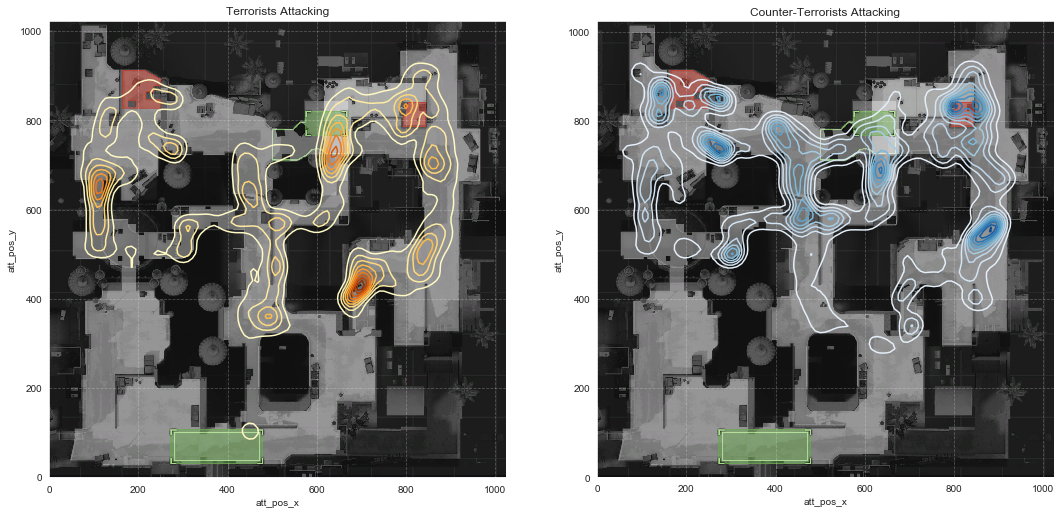

In [9]:
smap = 'de_dust2'

bg = imread(r'C:\Users\hp\Downloads\Compressed\csgo-matchmaking-damage/'+smap+'.png')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,16))
ax1.grid(b=True, which='major', color='w', linestyle='--', alpha=0.25)
ax2.grid(b=True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
ax2.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)

plot_df = df_pistol.loc[(df_pistol.map == smap) & (df_pistol.att_side == 'Terrorist')]
sns.kdeplot(plot_df['att_pos_x'], plot_df['att_pos_y'], cmap='YlOrBr', bw=15, ax=ax1)
ax1.set_title('Terrorists Attacking')

plot_df = df_pistol.loc[(df_pistol.map == smap) & (df_pistol.att_side == 'CounterTerrorist')]
sns.kdeplot(plot_df['att_pos_x'], plot_df['att_pos_y'], cmap='Blues', bw=15, ax=ax2)
ax2.set_title('Counter-Terrorists Attacking')

Text(0.5, 1.0, 'Counter-Terrorists Attacking')

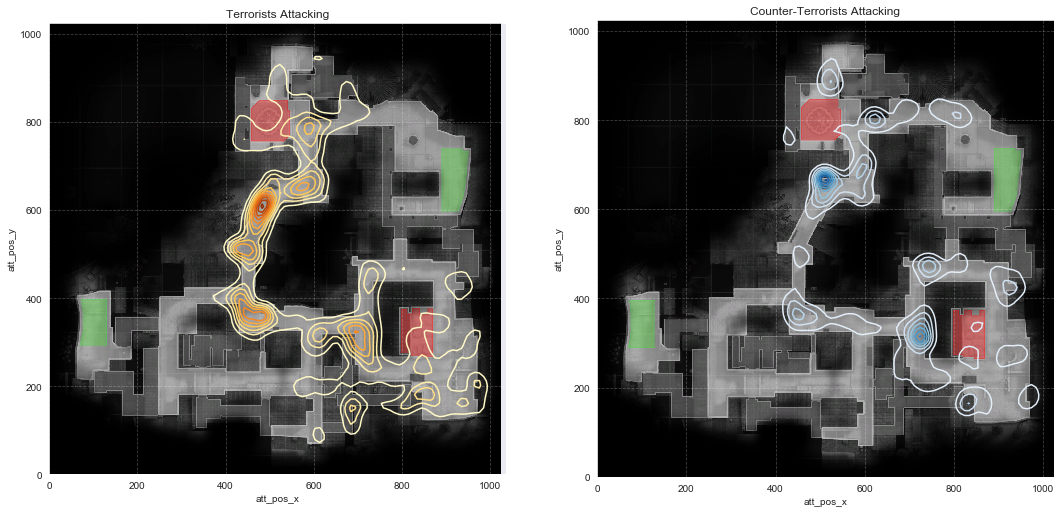

In [10]:
smap = 'de_inferno'

bg = imread(r'C:\Users\hp\Downloads\Compressed\csgo-matchmaking-damage/'+smap+'.png')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,16))
ax1.grid(b=True, which='major', color='w', linestyle='--', alpha=0.25)
ax2.grid(b=True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
ax2.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)

plot_df = df_pistol.loc[(df_pistol.map == smap) & (df_pistol.att_side == 'Terrorist')]
sns.kdeplot(plot_df['att_pos_x'], plot_df['att_pos_y'], cmap='YlOrBr', bw=15, ax=ax1)
ax1.set_title('Terrorists Attacking')

plot_df = df_pistol.loc[(df_pistol.map == smap) & (df_pistol.att_side == 'CounterTerrorist')]
sns.kdeplot(plot_df['att_pos_x'], plot_df['att_pos_y'], cmap='Blues', bw=15, ax=ax2)
ax2.set_title('Counter-Terrorists Attacking')

ADR by Pistols
Next let's take a look at the average damage per round dealt by a player given their pistol. Note that if they had picked up a pistol during the round, it does get counted separately. However, given that most pistol kills are headshots, it shouldn't skew the statistic that much (especially for USPS).

In [11]:
df_pistol.groupby(['file', 'round', 'wp', 'att_id'])['hp_dmg'].sum().groupby('wp').agg(['count', 'mean']).sort_values(by='mean')

,count,mean
wp,,
Tec9,586,87.288396
CZ,199,90.592965
P250,1058,90.811909
FiveSeven,612,91.942810
DualBarettas,158,93.348101
Glock,7591,94.766566
P2000,1371,98.170678
USP,8118,98.827544
Deagle,471,100.252654


Deagle has a massive advantage in damage

Bomb Site Plants
Let's now look at the Number of bomb plants by site. This statistic tells us the T's preferences for deciding which site to take during the round. Although the possibility of rotates are always there, it gives us a good idea of what to expect.

In [12]:
df_pistol[~df_pistol['bomb_site'].isnull()].groupby(['file', 'map', 'round', 'bomb_site'])['tick'] \
        .first().groupby(['map', 'bomb_site']).count().unstack('bomb_site')

bomb_site,A,B
map,,
de_cache,158,133
de_cbble,32,39
de_dust2,186,134
de_inferno,105,79
de_mirage,180,263
de_overpass,27,55
de_train,20,33


Post-plant Win Probabilities by Advantages
This one could be further disseminated but we want to be able to look at the win probabilities post plant given the context of how many Ts and CTs are alive at that time. First, we can look at overall statistic:

In [13]:
bomb_prob_overall = df_pistol[~df_pistol['bomb_site'].isnull()].groupby(['file', 'round', 'map', 'bomb_site', 'winner_side'])['tick'].first().groupby(['map', 'bomb_site', 'winner_side']).count()
bomb_prob_overall_pct = bomb_prob_overall.groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum()))
bomb_prob_overall_pct.unstack('map')

map                          de_cache   de_cbble   de_dust2  de_inferno  \
bomb_site winner_side                                                     
A         CounterTerrorist  26.582278  40.625000  20.967742   22.857143   
          Terrorist         73.417722  59.375000  79.032258   77.142857   
B         CounterTerrorist  27.819549  25.641026  30.597015   17.721519   
          Terrorist         72.180451  74.358974  69.402985   82.278481   

map                         de_mirage  de_overpass   de_train  
bomb_site winner_side                                          
A         CounterTerrorist  29.444444    29.629630  35.000000  
          Terrorist         70.555556    70.370370  65.000000  
B         CounterTerrorist  28.897338    23.636364  42.424242  
          Terrorist         71.102662    76.363636  57.575758

### Well till here we were dealing with the written and mathematical datas behind the various mechanism
### taking place inside CS:GO matches.

### Now we will plot some graphs and visualize the models and will see what really happens behind a counter strike match.

In [14]:
#our datas

df.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198123082770,17,879.012211,556.219455,698.835049,427.555690,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,282.865738,491.611838,289.018395,512.187455,PISTOL_ROUND,2950,3850,16.0
2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,295.771512,514.363983,285.908658,489.301445,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,291.449757,487.954345,298.390670,520.358553,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,298.227070,522.777461,294.860056,489.363485,PISTOL_ROUND,2950,3850,16.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918167 entries, 0 to 918166
Data columns (total 32 columns):
file               918167 non-null object
map                918167 non-null object
date               918167 non-null object
round              918167 non-null int64
tick               918167 non-null int64
seconds            918167 non-null float64
att_team           918167 non-null object
vic_team           918167 non-null object
att_side           918167 non-null object
vic_side           918167 non-null object
hp_dmg             918167 non-null int64
arm_dmg            918167 non-null int64
is_bomb_planted    918167 non-null bool
bomb_site          146777 non-null object
hitbox             918167 non-null object
wp                 918167 non-null object
wp_type            918167 non-null object
award              918167 non-null int64
winner_team        918167 non-null object
winner_side        918167 non-null object
att_id             918167 non-null int64
att_rank      

In [ ]:
#we dont require much af the data and we write them off from the visualization.Datas such as file,date,tick,seconds doesnt
#matter much,at least at this point of time so we drop such column.

#this is called cleaning of data.


In [16]:
df.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198123082770,17,879.012211,556.219455,698.835049,427.555690,PISTOL_ROUND,2950,3850,16.0
1,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,282.865738,491.611838,289.018395,512.187455,PISTOL_ROUND,2950,3850,16.0
2,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,295.771512,514.363983,285.908658,489.301445,PISTOL_ROUND,2950,3850,16.0
3,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,76561198051040004,17,291.449757,487.954345,298.390670,520.358553,PISTOL_ROUND,2950,3850,16.0
4,003201673717864202280_0171883906.dem,de_dust2,09/28/2017 8:44:22 PM,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,76561198223006752,16,298.227070,522.777461,294.860056,489.363485,PISTOL_ROUND,2950,3850,16.0


In [17]:
df.columns

Index(['file', 'map', 'date', 'round', 'tick', 'seconds', 'att_team',
       'vic_team', 'att_side', 'vic_side', 'hp_dmg', 'arm_dmg',
       'is_bomb_planted', 'bomb_site', 'hitbox', 'wp', 'wp_type', 'award',
       'winner_team', 'winner_side', 'att_id', 'att_rank', 'vic_id',
       'vic_rank', 'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y',
       'round_type', 'ct_eq_val', 't_eq_val', 'avg_match_rank'],
      dtype='object')

In [18]:
df.drop(['file','date','tick','seconds','hp_dmg','arm_dmg','hitbox','att_id','att_rank','award','vic_id','vic_rank','att_pos_x','att_pos_y','vic_pos_x','vic_pos_y'],axis = 1,inplace = True)
df.head()

,map,round,att_team,vic_team,att_side,vic_side,is_bomb_planted,bomb_site,wp,wp_type,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Pistol,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
1,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Pistol,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
2,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,NaN,Glock,Pistol,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
3,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Pistol,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
4,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,NaN,Glock,Pistol,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0


In [19]:
df.drop(['wp_type'],axis = 1,inplace = True)

In [20]:
df.head()

,map,round,att_team,vic_team,att_side,vic_side,is_bomb_planted,bomb_site,wp,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
1,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
2,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,NaN,Glock,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
3,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,NaN,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
4,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,NaN,Glock,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918167 entries, 0 to 918166
Data columns (total 15 columns):
map                918167 non-null object
round              918167 non-null int64
att_team           918167 non-null object
vic_team           918167 non-null object
att_side           918167 non-null object
vic_side           918167 non-null object
is_bomb_planted    918167 non-null bool
bomb_site          146777 non-null object
wp                 918167 non-null object
winner_team        918167 non-null object
winner_side        918167 non-null object
round_type         918167 non-null object
ct_eq_val          918167 non-null int64
t_eq_val           918167 non-null int64
avg_match_rank     918167 non-null float64
dtypes: bool(1), float64(1), int64(3), object(10)
memory usage: 98.9+ MB


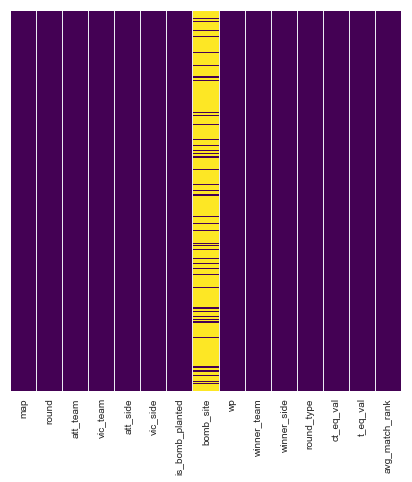

In [22]:
plt.figure(figsize = (7,7))
sns.heatmap(df.isnull(),yticklabels = False,cbar = False,cmap = 'viridis')

Here we can see we dont have much of the bombsite information so we can drop this column since it wont do any good in our visualization

In [23]:
df.drop(['bomb_site'],axis = 1,inplace = True)

In [24]:
df.head() #this is our actual real data after being cleaned that we are going to work with

,map,round,att_team,vic_team,att_side,vic_side,is_bomb_planted,wp,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
1,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
2,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,Glock,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
3,de_dust2,1,Team 1,Team 2,CounterTerrorist,Terrorist,False,USP,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0
4,de_dust2,1,Team 2,Team 1,Terrorist,CounterTerrorist,False,Glock,Team 1,CounterTerrorist,PISTOL_ROUND,2950,3850,16.0


In [25]:
df.shape

(918167, 14)

In [26]:
df.describe()

,round,ct_eq_val,t_eq_val,avg_match_rank
count,918167.000000,918167.000000,918167.000000,918167.000000
mean,13.523863,18411.496710,18114.324192,11.179350
std,7.856384,9537.686266,8320.145519,2.579731
min,1.000000,800.000000,1000.000000,7.000000
25%,7.000000,10150.000000,12500.000000,9.000000
50%,13.000000,20300.000000,20200.000000,11.000000
75%,20.000000,26450.000000,24800.000000,13.000000
max,30.000000,39000.000000,38700.000000,16.000000


In [ ]:
#deleating maps which are not in the active duty pool so that we get better pictures.

In [27]:
active_duty_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']
df = df[df['map'].isin(active_duty_maps)]
df = df.reset_index(drop=True)

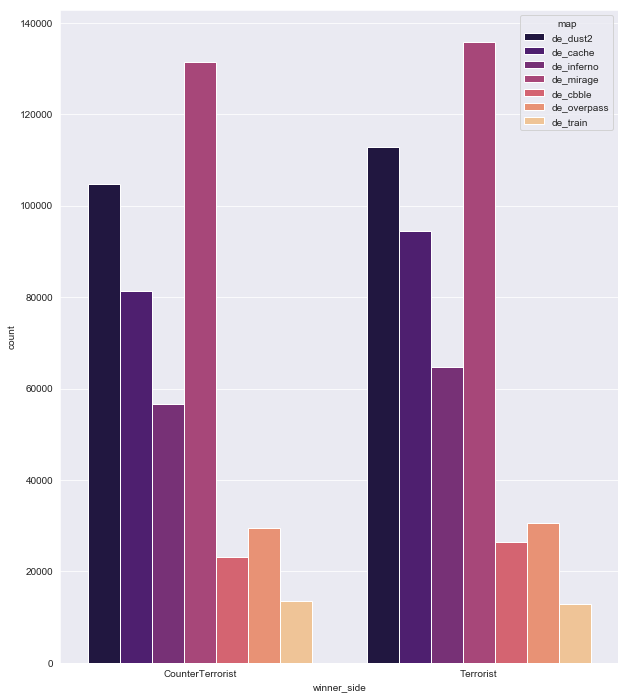

In [28]:
plt.figure(figsize = (10,12))
sns.countplot(x = 'winner_side',hue= 'map',data = df,palette = 'magma')

### Conclusion:-

### Dust 2 is T-sided
### Cache is T-sided
### Inferno is T-sided
### and same with rest other maps.

### But we can see from the table that winning a round is equally distributed on the maps Overpass and Train.
### Interesting...!

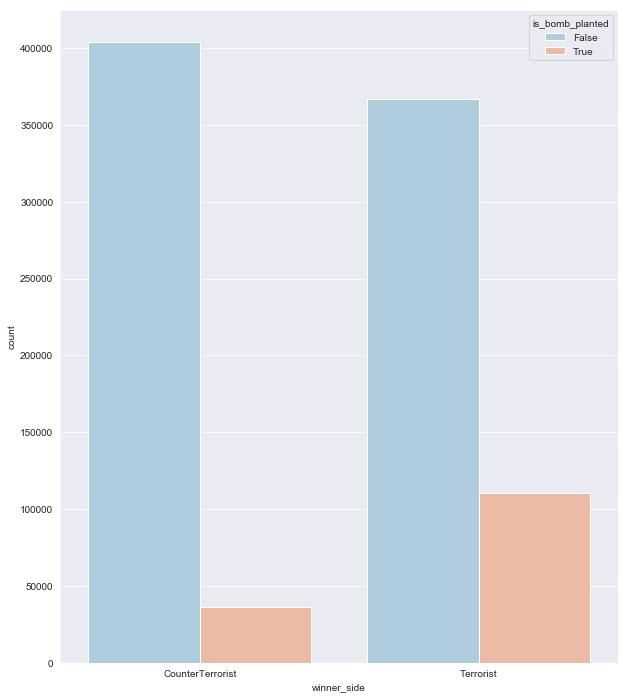

In [29]:
plt.figure(figsize = (10,12))
sns.countplot(x = 'winner_side',hue= 'is_bomb_planted',data = df,palette = 'RdBu_r')

After planting the bomb there is more probability of CT side to win the round.

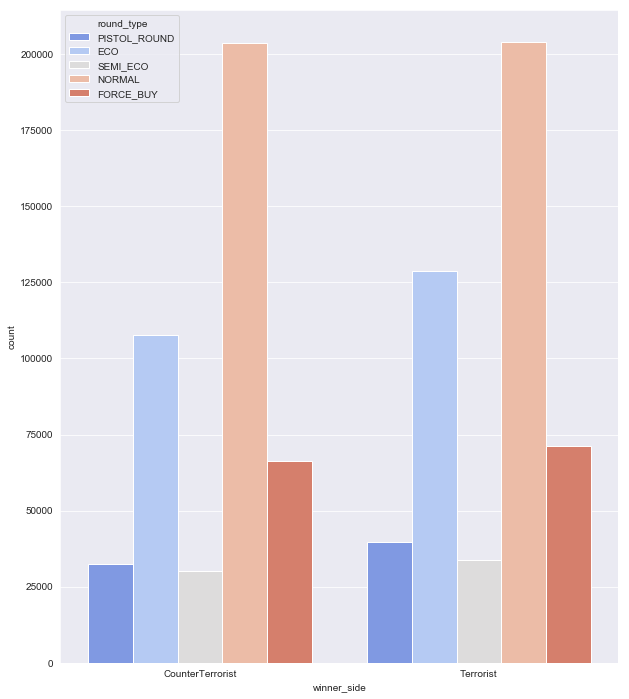

In [30]:
plt.figure(figsize = (10,12))
sns.countplot(x = 'winner_side',hue= 'round_type',data = df,palette = 'coolwarm')

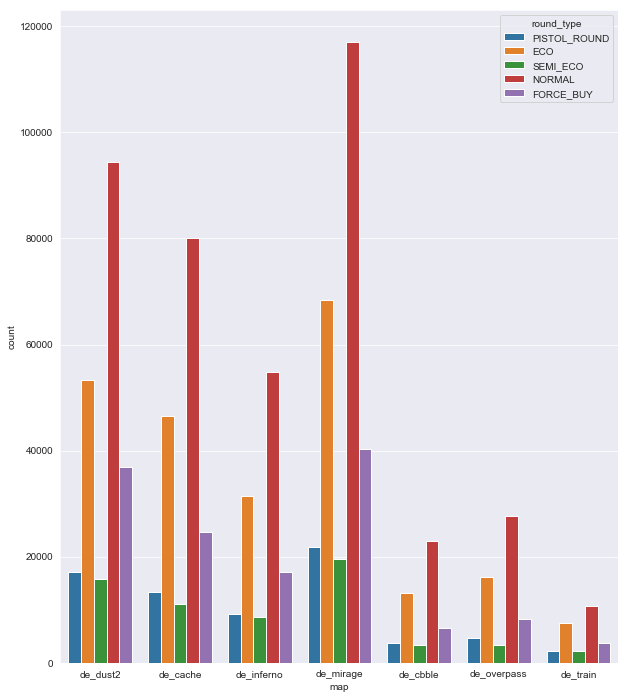

In [31]:
plt.figure(figsize = (10,12))
sns.countplot(x = 'map',hue= 'round_type',data = df)

Force buy and eco work well in Mirage..and works worst in inferno or overpass depending upon the frequency of matches you play.

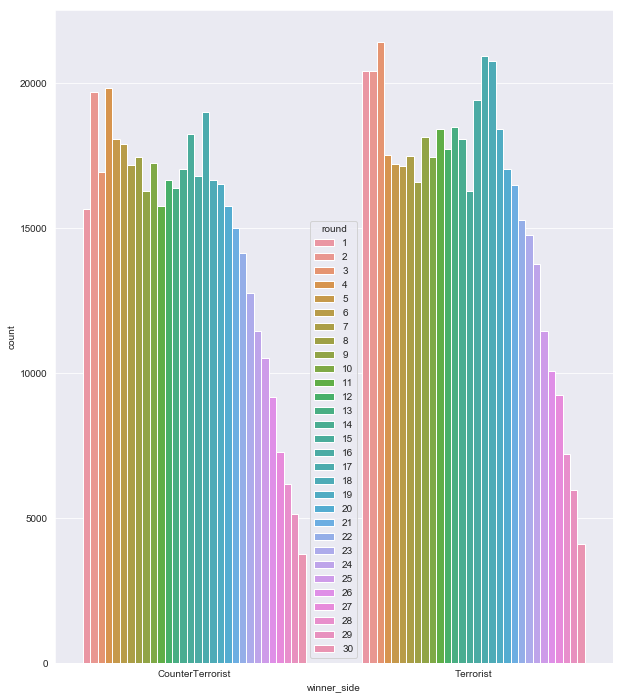

In [37]:
plt.figure(figsize = (10,12))
sns.countplot(x = 'winner_side',hue= 'round',data = df)

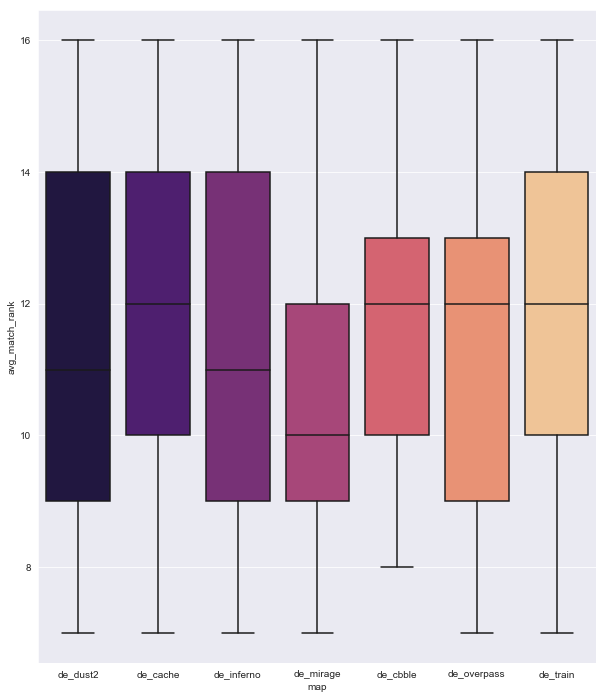

In [45]:
plt.figure(figsize = (8,10))
sns.boxplot(x = 'map',y = 'avg_match_rank',data = df,palette = 'magma')

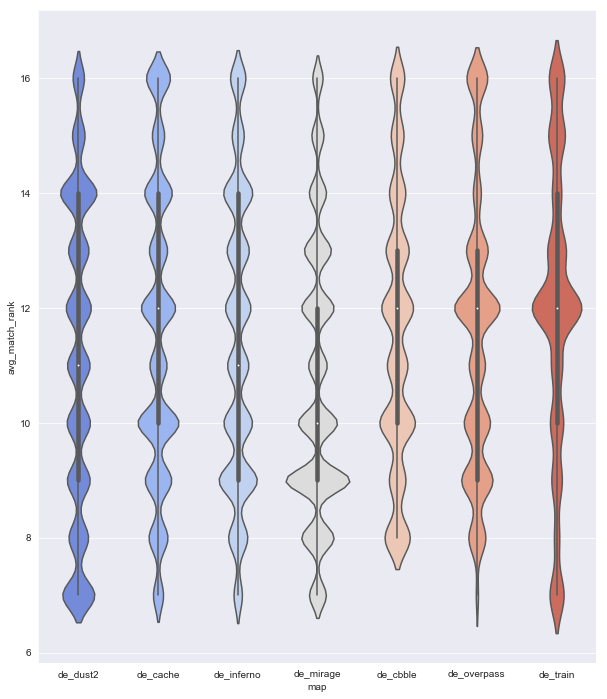

In [47]:
plt.figure(figsize = (10,12))
sns.violinplot(x = 'map',y = 'avg_match_rank',data = df,palette = 'coolwarm')

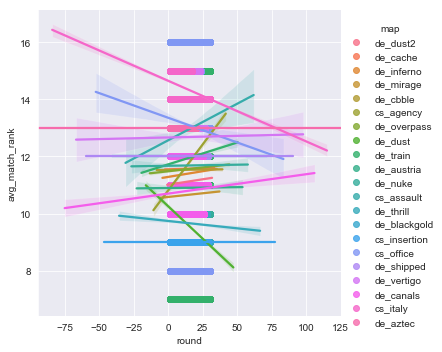

In [6]:
sns.lmplot(x = 'round',y = 'avg_match_rank',data = df,hue = 'map')